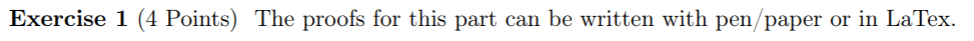

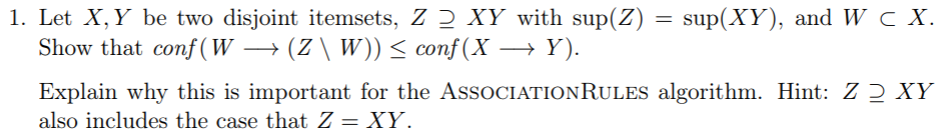

Podemos expresar la confianza de la regla $conf(W\rightarrow (Z|W))$ como:

$$conf(W\rightarrow (Z|W)) = \frac{sup(W) \cup (Z/W)}{sup(W) } $$

Dado que $Z\supseteq XY$ y $W \supseteq X$, podemos decir que $W \cup (Z/W) = Z$ porque Z contiene todos los elementos en $X$ y $Y$ y $W$ es un subconjunto de $X$. Así que:

$$sup(W\cup (Z/W))=sup(Z)$$

Teniendo en cuenta que $sup(Z)=sup(XY)$ entonces podemos escribir la confianza como:
$$conf(W\rightarrow (Z|W)) = \frac{sup(Z)}{sup(W)} = \frac{sup(XY)}{sup(W)}$$

Dado que $W\subset X$, entonces $sup(W)\le sup(X)$. Asi que podemos concluir que

$$\frac{sup(XY)}{sup(W)}\le \frac{sup(XY)}{sup(X)}$$

Este resultado es importante porque muestra que reducir la premisa de una regla no incrementa la confianza de la regla. Esto es clave para la generación de reglas de asociación pues asegura que se consideren unicamente las reglas más relevantes.